# Import

In [183]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Charger le jeu de test

In [185]:
# Charger le jeu de données d'entrainement pour les colonnes
test_df = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv') 
print('Testing Features shape: ', test_df.shape)
test_df

Testing Features shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [186]:
# Charger le jeu de données d'entrainement pour les colonnes
app_train = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv') 
print('Testing Features shape: ', app_train.shape)

Testing Features shape:  (307511, 122)


In [ ]:
import streamlit as st
import mlflow
import mlflow.sklearn

# Configurer MLflow pour utiliser le serveur distant avec les identifiants spécifiés
mlflow.set_tracking_uri("http://ec2-51-20-85-239.eu-north-1.compute.amazonaws.com:5000/")

In [194]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
from sklearn.impute import SimpleImputer

def preprocess_data(features, encoding='ohe'):

    # Extract the ids
    ids = features['SK_ID_CURR']

    # Remove the ids 
    features = features.drop(columns=['SK_ID_CURR'])

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    features = imputer.fit_transform(features)

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(pd.DataFrame(features))

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []

        # Iterate through each column
        for col in features.columns:
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape(-1,))
                cat_indices.append(col)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    # Add the ids back to the dataframes
    features['SK_ID_CURR'] = ids

    print('Training Data Shape: ', features.shape)

    return features, ids, cat_indices

In [195]:
features, ids, cat_indices = preprocess_data(test_df)

Training Data Shape:  (48744, 121)


# Prédictions

In [196]:
# Spécifiez le nom du modèle et la version que vous souhaitez récupérer
model_name = "GradientBoosting"  
model_version = 4

# Récupérer le modèle depuis MLflow
model_uri = f"models:/{model_name}/{model_version}"
loaded_model = mlflow.sklearn.load_model(model_uri)
print(f"Modèle chargé : {model_name} version {model_version}")
print(loaded_model.n_features_in_)  

Modèle chargé : GradientBoosting version 4
121


In [197]:
# Convertir les noms de colonnes en chaînes de caractères
features.columns = features.columns.astype(str)

# Vérifier les types de colonnes après conversion
print(features.dtypes)

0             float64
1             float64
2             float64
3             float64
4             float64
               ...   
116           float64
117           float64
118           float64
119           float64
SK_ID_CURR      int64
Length: 121, dtype: object


In [198]:
test_df_final=features.copy()

In [199]:
test_df_final

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,SK_ID_CURR
0,0.0,0.0,0.0,1.0,0.0,135000.0,568800.0,20560.5,450000.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100001
1,0.0,1.0,0.0,1.0,0.0,99000.0,222768.0,17370.0,180000.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,100005
2,0.0,1.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,7.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,100013
3,0.0,0.0,0.0,1.0,2.0,315000.0,1575000.0,49018.5,1575000.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,100028
4,0.0,1.0,1.0,0.0,1.0,180000.0,625500.0,32067.0,625500.0,6.0,...,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.0,0.0,0.0,1.0,0.0,121500.0,412560.0,17473.5,270000.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,456221
48740,0.0,0.0,0.0,0.0,2.0,157500.0,622413.0,31909.5,495000.0,6.0,...,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769,456222
48741,0.0,0.0,1.0,1.0,1.0,202500.0,315000.0,33205.5,315000.0,6.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,456223
48742,0.0,1.0,0.0,0.0,0.0,225000.0,450000.0,25128.0,450000.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,456224


In [200]:
# Effectuer les prédictions
y_pred_proba = loaded_model.predict_proba(test_df_final)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Ajouter les prédictions au DataFrame de test
test_df_final['PREDICTION'] = y_pred
test_df_final['PREDICTION_PROBA'] = y_pred_proba

/Users/gregoirehamy/Desktop/OpenClassrooms/Projet7/.envProjet7/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [201]:
test_df_final['PREDICTION_PROBA']

0        0.674707
1        0.204827
2        0.060490
3        0.095837
4        0.288152
           ...   
48739    0.218038
48740    0.050484
48741    0.125713
48742    0.242833
48743    0.292785
Name: PREDICTION_PROBA, Length: 48744, dtype: float64

In [202]:
output_file = 'predictions.csv'
test_df_final[['SK_ID_CURR', 'PREDICTION', 'PREDICTION_PROBA']].to_csv(output_file, index=False)
print(f"Prédictions sauvegardées dans {output_file}")

Prédictions sauvegardées dans predictions.csv


In [203]:
predictions_df = pd.read_csv('predictions.csv')
predictions_df.head(10)

,SK_ID_CURR,PREDICTION,PREDICTION_PROBA
0,100001,1,0.674707
1,100005,0,0.204827
2,100013,0,0.060490
3,100028,0,0.095837
4,100038,0,0.288152
5,100042,0,0.087973
6,100057,0,0.086203
7,100065,0,0.102845
8,100066,0,0.033734
9,100067,0,0.309808


In [204]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [205]:
predictions_df['PREDICTION'].value_counts()

PREDICTION
0    46442
1     2302
Name: count, dtype: int64

# Résultats

In [206]:
print("Nombre d'ID uniques dans app_train :", app_train["SK_ID_CURR"].nunique())
print("Nombre total de lignes dans app_train :", len(app_train))

print("Nombre d'ID uniques dans predictions_df :", predictions_df["SK_ID_CURR"].nunique())
print("Nombre total de lignes dans predictions_df :", len(predictions_df))

Nombre d'ID uniques dans app_train : 307511
Nombre total de lignes dans app_train : 307511
Nombre d'ID uniques dans predictions_df : 48744
Nombre total de lignes dans predictions_df : 48744


In [207]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

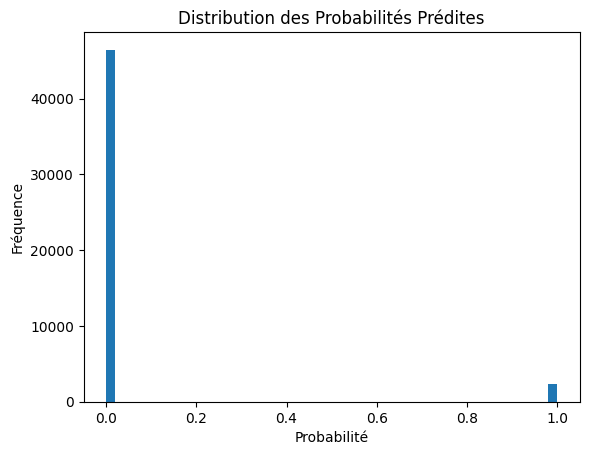

In [208]:
import matplotlib.pyplot as plt

# Faire des prédictions sur app_test
test_predictions = test_df_final['PREDICTION']

# Visualiser la distribution des probabilités prédites
plt.hist(test_predictions, bins=50)
plt.title('Distribution des Probabilités Prédites')
plt.xlabel('Probabilité')
plt.ylabel('Fréquence')
plt.show()


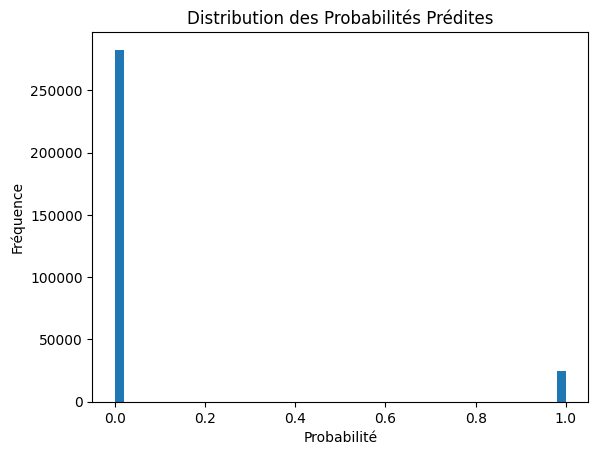

In [209]:
# Faire des prédictions sur app_test
train_predictions = app_train['TARGET']

# Visualiser la distribution des probabilités prédites
plt.hist(train_predictions, bins=50)
plt.title('Distribution des Probabilités Prédites')
plt.xlabel('Probabilité')
plt.ylabel('Fréquence')
plt.show()

# SHAP

In [210]:
import shap
from IPython.display import display
import matplotlib.pyplot as plt

In [211]:
# Demander à l'utilisateur de saisir le SK_ID_CURR
SK_ID_CURR = 100001

# Fonction pour afficher l'explication SHAP
def show_shap_explanation(SK_ID_CURR):
    # Créer un échantillon pour la perfomance
    background_sample = test_df_imputed.iloc[:100]
    
    # Vérifier si le SK_ID_CURR existe dans le DataFrame
    if SK_ID_CURR not in background_sample['SK_ID_CURR'].values:
        print(f"Erreur: SK_ID_CURR {SK_ID_CURR} non trouvé dans les données.")
        return

    # Trouver l'index de l'individu sélectionné
    index = background_sample[background_sample['SK_ID_CURR'] == SK_ID_CURR].index[0]

    # Initialize the SHAP JavaScript library
    shap.initjs()

    # SHAP Explainer
    explainer = shap.KernelExplainer(loaded_model.predict_proba, background_sample)
    shap_values = explainer.shap_values(background_sample.iloc[[index]])

    # Vérifiez la forme des valeurs SHAP
    print(f"Forme des valeurs SHAP: {shap_values.shape}")

    # Explain a single prediction
    print(f"Explication SHAP pour SK_ID_CURR: {SK_ID_CURR}")
    plot = shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], background_sample.iloc[index])

    # Afficher le graphique
    display(plot)

# Afficher l'explication SHAP pour le SK_ID_CURR saisi
show_shap_explanation(SK_ID_CURR)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.35s/it]

Forme des valeurs SHAP: (1, 121, 2)
Explication SHAP pour SK_ID_CURR: 100001


Prédiction finale : La valeur prédite par le modèle est de 0.69.

Contributions positives :
OCCUPATION_TYPE = 18 : Cette caractéristique contribue positivement de manière significative à la prédiction.
HOUSETYPE_MODE = 0 : Contribue également positivement.
EXT_SOURCE_1 = 0.7529 : Ajoute une contribution positive.

Contributions négatives :
ELEVATORS_MODE = 0.98651 : Cette caractéristique a une contribution négative notable.
OBS_60_CNT_SOCIAL_CIRCLE = 0 : Contribue négativement.
EXT_SOURCE_3 : Ajoute une légère contribution négative.

Interprétation globale : Les caractéristiques en rouge augmentent la prédiction, tandis que celles en bleu la diminuent. La longueur des barres indique l'ampleur de l'impact de chaque caractéristique sur la prédiction finale.

In [212]:
# SHAP Explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer(background_sample)

# Initialize the SHAP JavaScript library
shap.initjs()

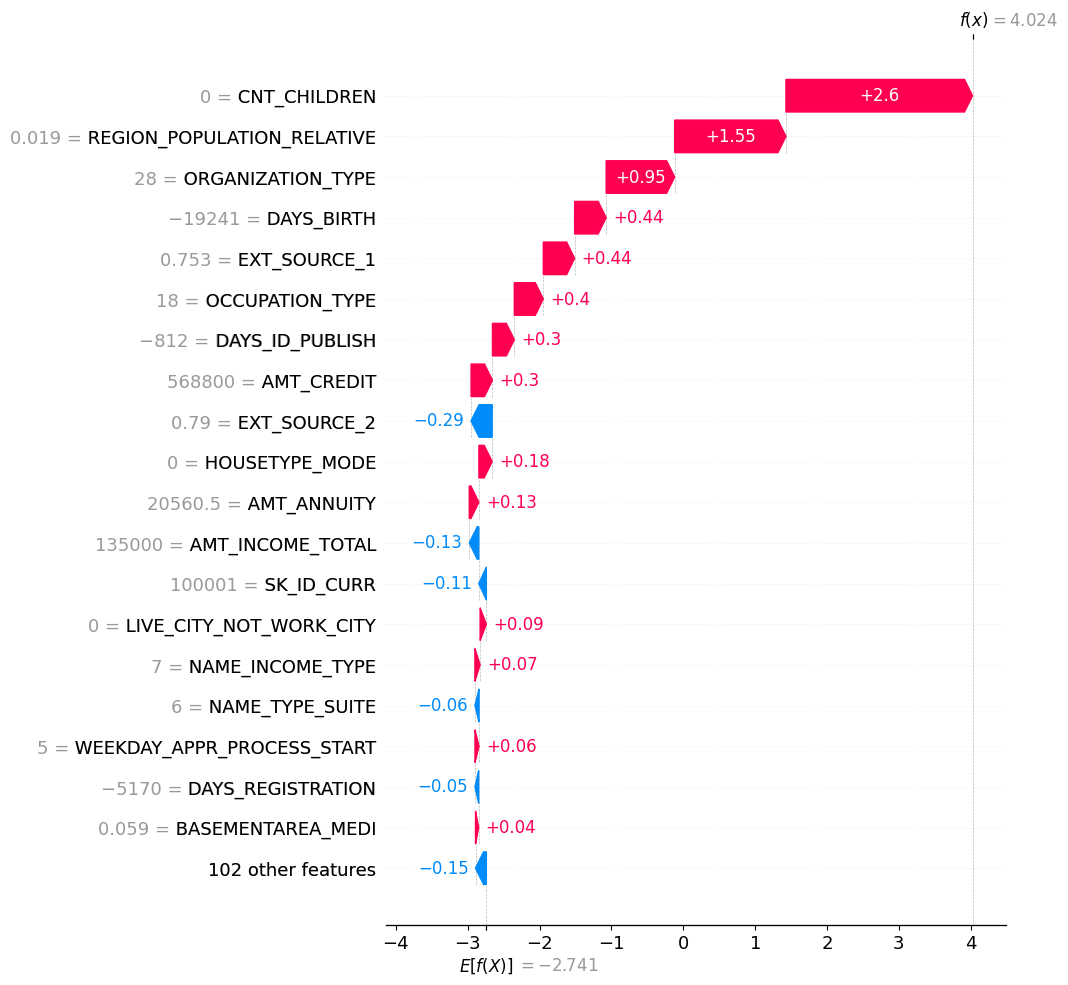

In [215]:
# Feature importance globale
shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0],
    base_values=shap_values.base_values[0],
    data=background_sample.iloc[0]
), max_display=20)

Contributions principales :
Positives :
CNT_CHILDREN (0 enfants) : +2.6
REGION_POPULATION_RELATIVE : +1.55
ORGANIZATION_TYPE : +0.95

Négatives :
EXT_SOURCE_2 : -0.29
AMT_INCOME_TOTAL : -0.13

Impact global : Les caractéristiques augmentent la prédiction de base de -2.741 à 4.024, avec certaines caractéristiques ayant un impact significatif (positif ou négatif) sur la prédiction.